In [1]:
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import h5py
import pickle
import seaborn as sns
import tqdm

from scipy import stats

from statsmodels.stats.multitest import multipletests

import sys
import itertools
import time
import datetime

sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import * 
import snmcseq_utils

from enhancer_gene_hic_validation_utils import *

import importlib
importlib.reload(pd)

<module 'pandas' from '/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/pandas/__init__.py'>

In [2]:
default_colorbar_kws = DEFAULT_COLORBAR_KWS
today = datetime.date.today()
print(today)

2020-12-13


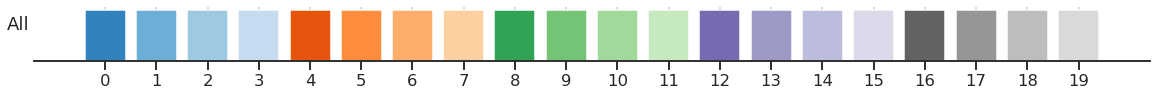

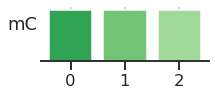

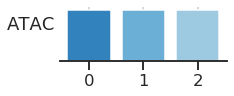

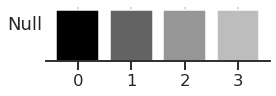

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [4]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000


In [5]:
chromosomes = ['chr'+str(i+1) for i in range(22)] + ['chrX']
celltypes = ['L2_3', 'L4', 'L5', 'L6', 
             'Pvalb', 'Sst', 'Vip', 'Ndnf']
resolution = 10000

# prepare data

In [6]:
df_genes = pd.read_csv(GENEBODY, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gid')
df_genes.head()

,gene_id,gene_name,chr,start,end,strand,gene_type
gid,,,,,,,
ENSMUSG00000102693,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [7]:
# enhancers lifted
f = './hic_from_ethan/enhancers_lifted.bed'
enh_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'enh_id'])
enh_list['center'] = (enh_list['start'] + enh_list['end'])/2
print(enh_list.shape)
enh_list.head()

# tss lifted
f = './hic_from_ethan/tss_lifted.bed'
tss_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'gid'])
print(tss_list.shape)
tss_list.head()

# enh - tss linked list
# orig significant pairs (enh_index and gid)
f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_mc.tsv'
linked_pairs_mc = pd.read_csv(f, sep="\t")
print(linked_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_atac.tsv'
linked_pairs_atac = pd.read_csv(f, sep="\t")
print(linked_pairs_atac.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_mc.tsv'
correlated_pairs_mc = pd.read_csv(f, sep="\t")
print(correlated_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_atac.tsv'
correlated_pairs_atac = pd.read_csv(f, sep="\t")
print(correlated_pairs_atac.shape)

# both
linked_pairs_both = pd.merge(linked_pairs_mc, linked_pairs_atac, on=['gene', 'enh', 'dist'])
correlated_pairs_both = pd.merge(correlated_pairs_mc, correlated_pairs_atac, on=['gene', 'enh', 'dist'])
print(linked_pairs_both.shape, 
      correlated_pairs_both.shape, 
     )

linked_pairs_both.head()

(126134, 5)
(33814, 4)
(7455, 3)
(3879, 3)
(85596, 3)
(50012, 3)
(1268, 3) (35309, 3)


,gene,enh,dist
0,ENSMUSG00000000440,191533,39294
1,ENSMUSG00000000440,191534,38506
2,ENSMUSG00000000531,87150,9780
3,ENSMUSG00000000531,87153,11927
4,ENSMUSG00000000552,87351,2705


In [8]:
# gene expression profiles
f = '/sphere/fangming/enhancers/scripts/data_organized/gene_rna_clsts.tsv'
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0) #header=True, index=True)
print(gene_rna_clsts.shape)
gene_rna_clsts.head()

# cluster annotation
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/annotations_order.tsv'
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(12095, 38)
(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

In [9]:
# merge cluster name
annot_rename_lookup = {
    'L2/3': "L2_3",
    'L4/5': "L4",
    'L6b': "L6",
    'Sncg': "Ndnf",
    'Lamp5': "Ndnf",
}

def rename_annot(x, annot_rename_lookup):
    """
    """
    if x in annot_rename_lookup.keys():
        return annot_rename_lookup[x]
    else:
        return x

def summarize_by_broad_clsts(df, clst_annot_broad):
    """
    df - feature by clusters
    clst_annot_board - clusters -> coarse grained clusters
    """
    
    df = df.T.copy()
    df['broad_clst'] = clst_annot_broad.reindex(df.index).values
    df = df.groupby('broad_clst', sort=True).mean().T
    
    return df
    
clst_annot_broad = pd.Series([annot.split(' ')[0] for annot in clst_annot.values], 
                             index=clst_annot.index)
clst_annot_broad = clst_annot_broad.apply(lambda x: rename_annot(x, annot_rename_lookup))

print(clst_annot_broad.shape, 
      len(np.unique(clst_annot_broad.values)),
      np.unique(clst_annot_broad.values),
     )

(38,) 8 ['L2_3' 'L4' 'L5' 'L6' 'Ndnf' 'Pvalb' 'Sst' 'Vip']


In [10]:
# enhancers and genes original
# gene list
dirc = '/sphere/fangming/enhancers/scripts/data_organized/'
with snmcseq_utils.cd(dirc):
    f = 'gene_list.txt'
    genes_list_orig = pd.read_csv(f, sep='\t',)
    print(genes_list_orig.shape)

    # enh list
    f = 'enh_list.txt'
    enh_list_orig = pd.read_csv(f, sep='\t',)
    print(enh_list_orig.shape)

    # pair list
    f = 'pair_list.txt'
    to_evals = pd.read_csv(f, sep='\t',)
    print(to_evals.shape)

    f = 'shared_clusters.txt'
    shared_clusters = snmcseq_utils.import_single_textcol(f)
    print(shared_clusters.shape)
    
    f = 'gene_rna_clsts.tsv.gz'
    gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0)
    print(gene_rna_clsts.shape)
    
    f = 'gene_mch_clsts.tsv.gz'
    gene_mch_clsts = pd.read_csv(f, sep='\t', index_col=0)
    print(gene_mch_clsts.shape)
    
    f = 'enh_mcg_clsts.tsv.gz'
    enh_mcg_clsts = pd.read_csv(f, sep='\t', index_col=0)
    print(enh_mcg_clsts.shape)
    
    f = 'enh_atac_clsts.tsv.gz'
    enh_atac_clsts = pd.read_csv(f, sep='\t', index_col=0)
    print(enh_atac_clsts.shape)

(12095, 11)
(152104, 8)


/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1710144, 4)
(38,)
(12095, 38)
(12095, 38)
(152104, 38)
(152104, 38)


# Plot function 

In [11]:
from matplotlib.patches import Rectangle
def plot_mat(mat_all, enh_bin, gene_bin, enh_name, gene_name):
    """
    """
    min_bin = min(enh_bin, gene_bin)
    max_bin = max(enh_bin, gene_bin)
    window = max_bin - min_bin
    pad = max(3, int(0.2*window))
    min_bin = min_bin - pad
    max_bin = max_bin + pad 

    title = "{} {} (bin size={:,})".format(celltype, chromosome, resolution)

    mat = mat_all[min_bin:max_bin, min_bin:max_bin] 
    max_diag = np.max(np.diag(mat))
    max_offdiag = np.max(np.triu(mat, k=1)) 

    # plot 
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(
                mat,
                cmap='rocket_r',
                cbar_kws={'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, 
                          'pad': 0.2,
                          'label': "Contact frequency",
                          'ticks': np.arange(0, max_offdiag, 0.05),
                         },
                vmax=max_offdiag,
                rasterized=True,
                ax=ax,
               )
    ax.set_xlim([0, len(mat)])
    ax.set_ylim([len(mat), 0])
    ax.set_aspect('equal')
    ax.set_title(title)
    
    # ticks
    ticks_simple = np.array([0, max_bin-min_bin])
    ticks = np.arange(0, max_bin-min_bin, 10)
    if max_bin-min_bin not in ticks:
        ticks = np.hstack([ticks, [max_bin-min_bin]])
    ax.set_xticks(ticks_simple)
    ax.set_xticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks_simple],
                       rotation=0,
                      )
    ax.set_yticks(ticks)
    ax.set_yticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks], 
                       rotation=0,
                      )
    ax.yaxis.tick_right()
    
    # box, lines, text
    if enh_bin < gene_bin:
        idx_pos = (enh_bin - min_bin) # x enh
        idy_pos = (gene_bin - min_bin) # y gene
        # texts by the lines
        ax.text(idx_pos, max_bin-min_bin+0.1, enh_name, va='top', fontsize=8)
        ax.text(0, idy_pos, gene_name, ha='right', va='center', fontsize=15)
    else:
        idx_pos = (gene_bin - min_bin) # x gene 
        idy_pos = (enh_bin - min_bin) # y enh
        # texts by the lines
        ax.text(idx_pos, max_bin-min_bin+0.1, gene_name, va='top', fontsize=15)
        ax.text(0, idy_pos, enh_name, ha='right', va='center', fontsize=8)
        
    # rectangle
    rec = Rectangle((idx_pos, idy_pos), 1, 1, fill=False, edgecolor='black')
    ax.add_patch(rec)
    
    # asterisk
    ax.text(idy_pos+0.5, idx_pos+0.5, '*', ha='center',va='center', fontsize=15, color='white')
    
    # lines
    ax.vlines(idx_pos, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
    ax.vlines(idx_pos+1, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
    
    ax.hlines(idy_pos, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    ax.hlines(idy_pos+1, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    
    plt.show()

In [12]:
def plot_mat_multi_enh_ax(fig, ax, mat_all, enh_bins, gene_bin, enh_names, gene_name, 
                          celltype, normalize=True,
                          vmin=0, vmax=1,
                          pad_ratio=0.2, plot_ticks=True, **kw_cbars):
    """
    """
    enh_bins_min = np.min(enh_bins)
    
    min_bin = min(enh_bins_min, gene_bin)
    max_bin = max(enh_bins_min, gene_bin)
    pad = max(3, int(pad_ratio*(max_bin - min_bin)))
    min_bin = min_bin - pad
    max_bin = max_bin + pad 

    title = "{}".format(celltype)

    mat = mat_all[min_bin:max_bin, min_bin:max_bin] 
    max_diag = np.max(np.diag(mat))
    max_offdiag = np.max(np.triu(mat, k=1)) 

    # plot 
    if normalize:
        _plotmat = mat/max_offdiag
        vmin, vmax = 0, 1
    else:
        _plotmat = mat
        
    g = sns.heatmap(
                    _plotmat,
                    cmap='rocket_r',
                    vmax=vmax,
                    vmin=vmin,
                    ax=ax,
                    rasterized=True,
                    **kw_cbars,
                    )
    ax.set_xlim([0, len(mat)])
    ax.set_ylim([len(mat), 0])
    ax.set_aspect('equal')
    ax.set_title(title)
    
    # ticks
    if plot_ticks:
        ticks_simple = np.array([0, max_bin-min_bin])
        ticks = np.arange(0, max_bin-min_bin, 10)
        if max_bin-min_bin not in ticks:
            ticks = np.hstack([ticks, [max_bin-min_bin]])
        ax.set_xticks(ticks_simple)
        ax.set_xticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks_simple],
                           rotation=0,
                          )
        ax.set_yticks([])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # box, lines, text
    flag_genex = flag_geney = False
    for j, (enh_bin, enh_name) in enumerate(zip(enh_bins, enh_names)):
        # box, lines, text
        if enh_bin < gene_bin:
            idx_pos = (enh_bin - min_bin) # x enh
            idy_pos = (gene_bin - min_bin) # y gene
            
            if plot_ticks:
                # texts by the lines
                ax.text(idx_pos, max_bin-min_bin+0.1, enh_name, va='top', fontsize=8, rotation=90)
                if not flag_geney:
                    ax.text(0, idy_pos, gene_name, ha='right', va='center', fontsize=15)

                flag_geney = True
        else:
            idx_pos = (gene_bin - min_bin) # x gene 
            idy_pos = (enh_bin - min_bin) # y enh
            
            if plot_ticks:
                # texts by the lines
                if not flag_genex:
                    ax.text(idx_pos, max_bin-min_bin+0.1, gene_name, va='top', fontsize=15)
                ax.text(0, idy_pos, enh_name, ha='right', va='center', fontsize=8)

                flag_genex = True

        # rectangle
        rec = Rectangle((idx_pos, idy_pos), 1, 1, fill=False, edgecolor='black')
        ax.add_patch(rec)

#         # asterisk
#         ax.text(idy_pos+0.5, idx_pos+0.5, '*', ha='center',va='center', fontsize=15, color='white')

        # lines
        ax.vlines(idx_pos, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
        ax.vlines(idx_pos+1, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)

        ax.hlines(idy_pos, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
        ax.hlines(idy_pos+1, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    return ax, g

In [13]:
def plot_mat_multi_enh_wholefig(celltypes, mats_all, enh_bins, gene_bin, enh_names, gene_name, choromosome, resolution, 
                                normalize=True,
                                vmin=0, vmax=1,
                               ):
    """
    """
    if normalize:
        cbar_kws = {'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, # 'pad': 0.2,
                      'label': "Contact frequency\n(Norm. by the max offdiag of each mat)",
                      'ticks': [0, 0.5, 1],
                   }
        vmin, vmax = 0, 1
    else:
        cbar_kws = {'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, # 'pad': 0.2,
                    'label': "Contact frequency",
                    'ticks': np.arange(0, vmax+1e-7, 0.05),
                   }
    pad_ratio = 0.5
    
    fig, axs = plt.subplots(2, 4, figsize=(5*4, 5*2))
    cbar_ax = fig.add_axes([0.95, 0.4, 0.02, 0.2])
    for i, (celltype) in tqdm.tqdm(enumerate(celltypes)):
        ax = axs.flat[i]
        if i == 0:
            plot_ticks = True
            cbar = True 
            cbar_ax = cbar_ax
        else:
            plot_ticks = False
            cbar = False
            cbar_ax = cbar_ax

        mat_all = mats_all["{} {}".format(celltype, chromosome)]
        ax, g = plot_mat_multi_enh_ax(fig, ax, mat_all, enh_bins, gene_bin, enh_names, gene_name, 
                                      celltype,
                                      normalize=normalize,
                                      vmin=vmin, 
                                      vmax=vmax,
                                      pad_ratio=pad_ratio,
                                      plot_ticks=plot_ticks, cbar=cbar, cbar_ax=cbar_ax, cbar_kws=cbar_kws)

    suptitle = "{} {} (bin size={:,})".format(gene_name, chromosome, resolution)
    fig.suptitle(suptitle, y=0.98, fontsize=15) 

    output_tag = "norm" if normalize else "nonorm"
    output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
                  'hic_map_{}_{}_{}_{}.pdf'.format(output_tag, gene_name, resolution, today)
                 )
    print(output_fig)
    snmcseq_utils.savefig(fig, output_fig)

    plt.show()
    
    return

# A specific gene -- Stim2 promising!

In [14]:
resolution = 10000
gene_name = 'Stim2'

try:
    gene_id = df_genes.reset_index().set_index('gene_name').loc[gene_name, 'gid']

    linked_pairs_todo = linked_pairs_both[linked_pairs_both['gene']==gene_id]
    chromosome_spec = tss_list.set_index('gid').loc[gene_id, 'chr']

    print(linked_pairs_todo.shape)
    print(chromosome_spec)
except:
    print("{} skipped".format(gene_name))
#         continue

# get a list of candidate pairs
chromosome = chromosome_spec
# all enhancers and tss on that chromosomes
enhs = enh_list[enh_list['chr']==chromosome]
tsss = tss_list[tss_list['chr']==chromosome]
# get paired bins
paired_bin_table = enh_gene_id_to_binidx(linked_pairs_todo, tsss, enhs, resolution)

(5, 3)
chr4


In [15]:
gene_bin = paired_bin_table['gene_bin'].iloc[0]
chromosome = chromosome_spec
enh_bins = np.sort(paired_bin_table['enh_bin'].values)
enh_names = ["{}:{:,},{:,}".format(_chr, _start, _end)
             for (_chr, _start, _end) in zip(paired_bin_table['enh_chr'], 
                                             paired_bin_table['enh_start'], 
                                             paired_bin_table['enh_end'])
            ]

# get relevant mats
mats_all = {}
for celltype in tqdm.tqdm(celltypes):
    resource_string = (
         '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
         '::/resolutions/{}'.format(celltype, resolution)
         )
    c = cooler.Cooler(resource_string)
    mat_all = c.matrix(balance=True).fetch(chromosome)
    
    name = "{} {}".format(celltype, chromosome)
    
    if name not in mats_all.keys(): 
        mats_all["{} {}".format(celltype, chromosome)] = mat_all
        
# get contacts on the specific location
contact_by_clsts = []
for i, (idx, row) in enumerate(paired_bin_table.iterrows()):
    gene_bin, enh_bin = row[['gene_bin', 'enh_bin']]
    
    for celltype in celltypes:
        mat_all = mats_all["{} {}".format(celltype, chromosome)]
        val = mat_all[gene_bin, enh_bin]
        contact_by_clsts.append({
                    'local_pair_idx': i,
                    'celltype': celltype,
                    'contact': val, 
                   })
        
contact_by_clsts = pd.DataFrame(contact_by_clsts)
contact_by_clsts = contact_by_clsts.pivot(index='local_pair_idx', columns='celltype')['contact']
print(contact_by_clsts.shape)
contact_by_clsts.head()

100%|██████████| 8/8 [00:22<00:00,  2.80s/it]

(4, 8)


celltype,L2_3,L4,L5,L6,Ndnf,Pvalb,Sst,Vip
local_pair_idx,,,,,,,,
0,0.005449,0.000000,0.015919,0.000000,0.009198,0.0,0.002237,0.009093
1,0.005449,0.000000,0.015919,0.000000,0.009198,0.0,0.002237,0.009093
2,0.014625,0.025603,0.010581,0.033600,0.004349,0.0,0.002112,0.009113
3,0.009636,0.014908,0.006950,0.048805,0.000000,0.0,0.002480,0.007871


8it [00:01,  7.21it/s]


/cndd2/fangming/projects/scf_enhancers/figures/hic_map_norm_Stim2_10000_2020-12-13.pdf


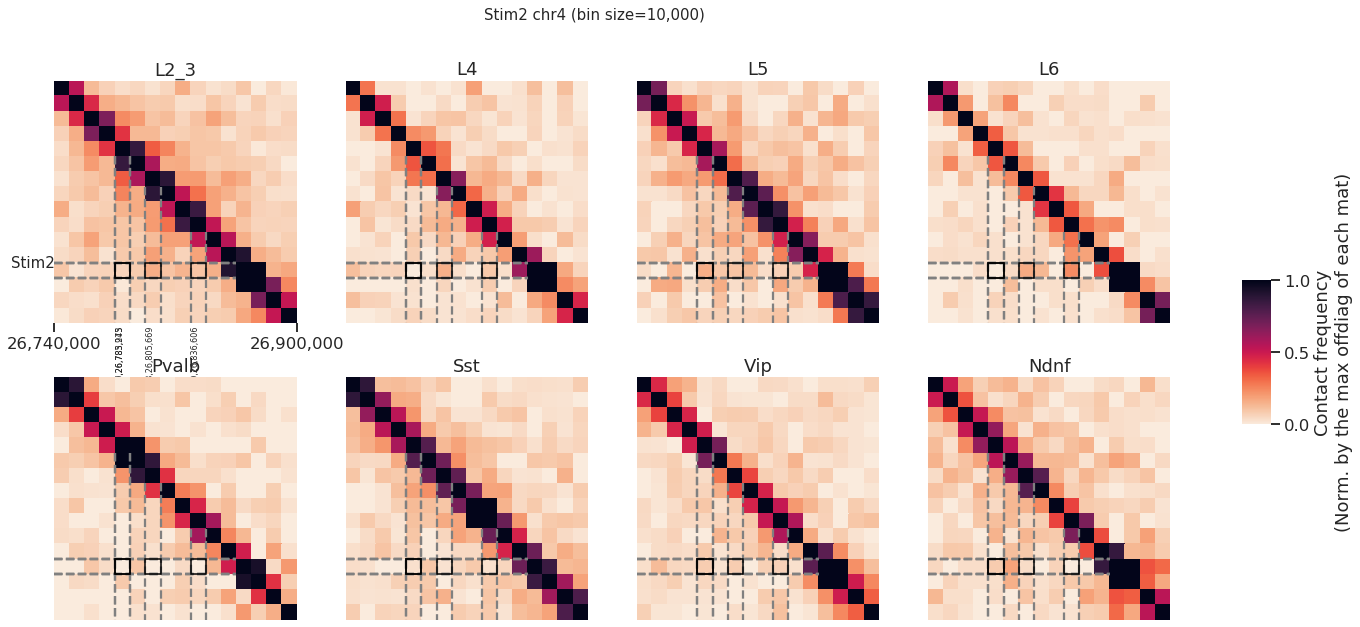

In [16]:
plot_mat_multi_enh_wholefig(celltypes, mats_all, 
                            enh_bins, gene_bin, enh_names, gene_name, 
                            chromosome, resolution) 

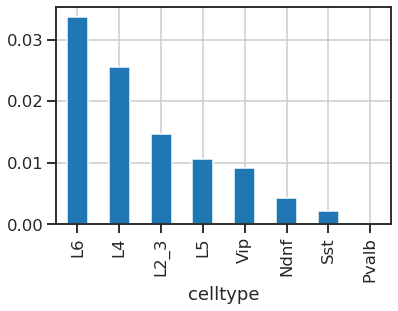

In [17]:
contact_by_clsts.iloc[2].T.sort_values(ascending=False).plot.bar(color='C0')

## find *Stim2* relevant info and plot

In [18]:
def plot_scatter1(gene_name, enh_names_orig, enh_names_lifted, 
                  ploty1, plotx1, plotx2, subplot_colors=[]):
    """
    """
    n = len(plotx1)
    ny = 2
    fig, axss = plt.subplots(n, ny, figsize=(ny*4, n*4), sharey=True)
    if n == 1:
        axss = np.array([axss])
    for j in np.arange(ny):
        axs = axss[:,j]
        _plotx = [plotx1, plotx2,][j]
        _ploty = ploty
        for i in np.arange(n):
            ax = axs[i]
            _x, _y = _plotx.iloc[i].values, _ploty.values
            _celltypes = _ploty.index.values
            if len(subplot_colors) == 0:
                ax.scatter(_x, _y, rasterized=True)
            else:
                ax.scatter(_x, _y, rasterized=True, color=subplot_colors[j])
                
            r, p = stats.spearmanr(_x, _y)
            ax.annotate("r={:.2f}".format(r), xy=(0.95, 0.05), xycoords=ax.transAxes, ha='right', va='bottom', 
                        fontsize=15,
                       )
    #         for __x, __y, __celltype in zip(_x, _y, _celltypes):
    #             ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)

            ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            xmin, xmax = np.min(_x), np.max(_x)
            xmin = xmin - 0.1*(xmax-xmin)
            xmax = xmax + 0.1*(xmax-xmin)
            ax.set_xlim(xmin, xmax)
            sns.despine(ax=ax)

            if j == 0:
                ax.set_xlabel('mCG')    
                ax.set_ylabel('RNA')    
                ax.invert_xaxis()
                ax.set_title("{} -> {}".format(enh_names_orig[i], enh_names_lifted[i]))
            elif j == 1:
                ax.set_xlabel('ATAC')    

    fig.subplots_adjust(hspace=0.5)

    output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
                  'scatter_38clusters_{}_{}.pdf'.format(gene_name, today)
                 )
    print(output_fig)
    snmcseq_utils.savefig(fig, output_fig)
    plt.show()

def plot_scatter2(gene_name, enh_names_orig, enh_names_lifted, 
                  plotyb1, plotxb1, plotxb2, plotxb3, subplot_colors=[]):
    """
    """
    n = len(plotxb1)
    ny = 3
    fig, axss = plt.subplots(n, ny, figsize=(ny*4, n*4), sharey=True)
    if n == 1:
        axss = np.array([axss])
    for j in np.arange(ny):
        axs = axss[:,j]
        _plotx = [plotxb1, plotxb2, plotxb3][j]
        _ploty = plotyb1
        for i in np.arange(n):
            ax = axs[i]
            _x, _y = _plotx.iloc[i].values, _ploty.iloc[0].values
            _celltypes = _ploty.columns
            if len(subplot_colors) == 0:
                ax.scatter(_x, _y, rasterized=True)
            else:
                ax.scatter(_x, _y, rasterized=True, color=subplot_colors[j])
            
            r, p = stats.spearmanr(_x, _y)
            ax.annotate("r={:.2f}".format(r), xy=(0.95, 0.05), xycoords=ax.transAxes, ha='right', va='bottom', 
                        fontsize=15,
                       )
            for __x, __y, __celltype in zip(_x, _y, _celltypes):
                ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)

            ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            xmin, xmax = np.min(_x), np.max(_x)
            xmin = xmin - 0.1*(xmax-xmin)
            xmax = xmax + 0.1*(xmax-xmin)
            ax.set_xlim(xmin, xmax)
            sns.despine(ax=ax)

            if j == 0:
                ax.set_xlabel('mCG')    
                ax.set_ylabel('RNA')    
                ax.invert_xaxis()
            elif j == 1:
                ax.set_title("{} -> {}".format(enh_names_orig[i], enh_names_lifted[i]))
                ax.set_xlabel('ATAC')    
            elif j == 2:
                ax.set_xlabel('HiC')    

    fig.subplots_adjust(hspace=0.5)
    output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
                  'scatter_8clusters_{}_{}.pdf'.format(gene_name, today)
                 )
    print(output_fig)
    snmcseq_utils.savefig(fig, output_fig)
    plt.show()
    
subplot_colors_mc_atac = [colors_mc[0], colors_atac[0]]
subplot_colors_mc_atac_hic = [colors_mc[0], colors_atac[0], colors_null[0]]

(4, 12)
ENSMUSG00000039156 [171576 171578 171584 171593] ['chr5_53926006_53926641', 'chr5_53927305_53928317', 'chr5_53942280_53943483', 'chr5_53969740_53970403'] ['chr4_26782570_26783245', 'chr4_26785007_26785973', 'chr4_26804388_26805669', 'chr4_26835900_26836606']
/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Stim2_2020-12-13.pdf


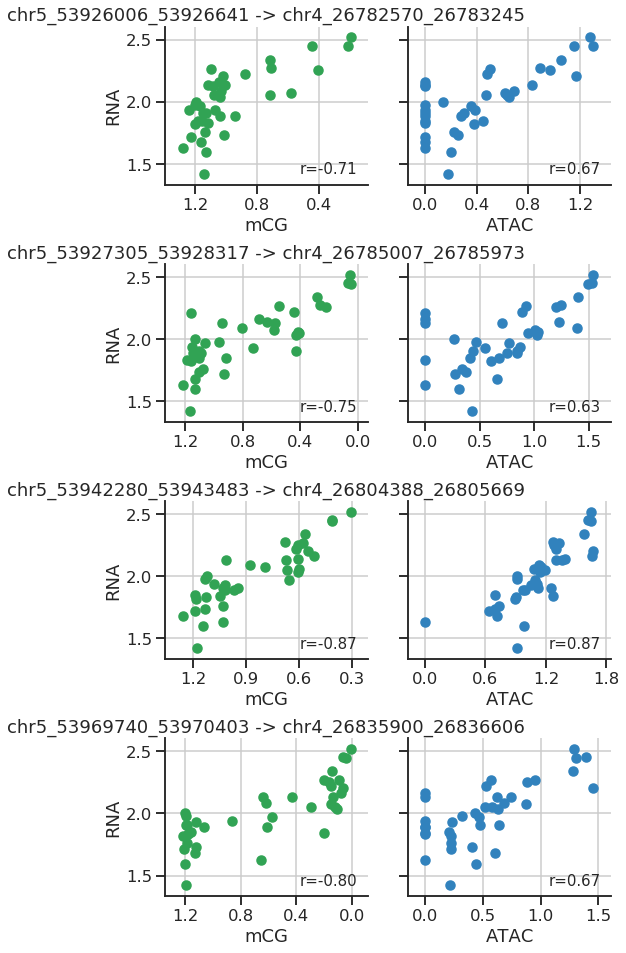

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Stim2_2020-12-13.pdf


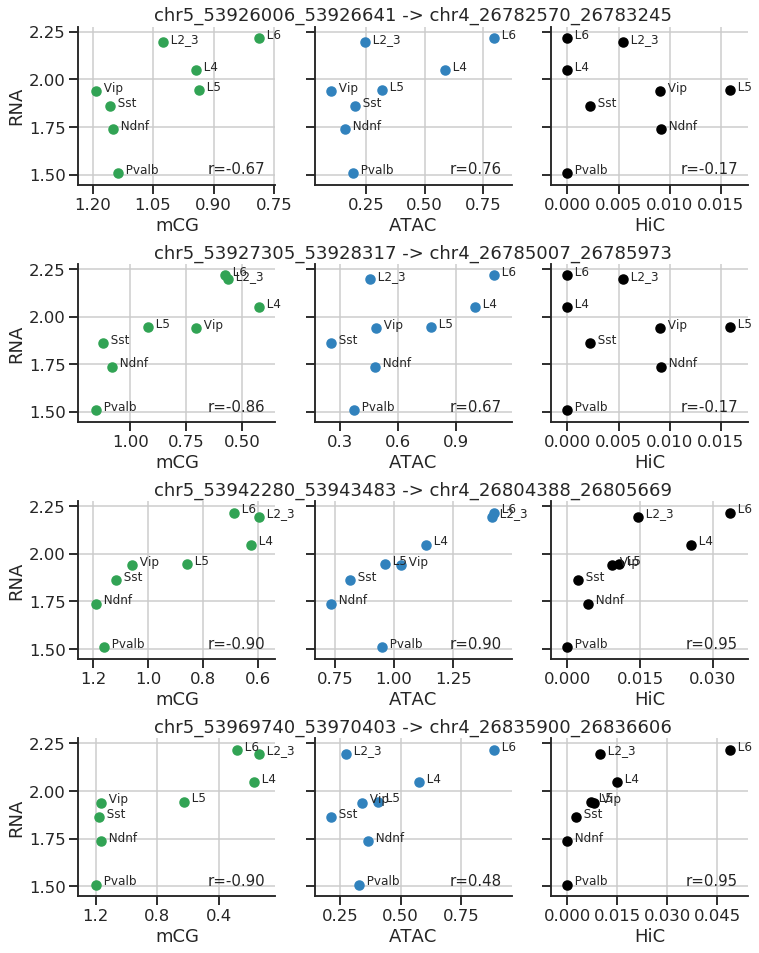

In [19]:
# start from this
print(paired_bin_table.shape)

# gene and enhs
gene_id = paired_bin_table['gene'].iloc[0]
enh_ids = paired_bin_table['enh'].values
enh_names_orig = ["_".join(enh_list_orig.set_index('index').loc[enh_id][['chr', 'start', 'end']].astype(str))
                        for enh_id in enh_ids]
enh_names_lifted = ["_".join(row[['enh_chr', 'enh_start', 'enh_end']].astype(str)) 
                        for idx, row in paired_bin_table.iterrows()]
                      
print(gene_id, enh_ids, enh_names_orig, enh_names_lifted)

# all info 
ploty = gene_rna_clsts.loc[gene_id, shared_clusters]
plotx1 = enh_mcg_clsts.loc[enh_ids, shared_clusters]
plotx2 = enh_atac_clsts.loc[enh_ids, shared_clusters]

# 38 clusters -> 8 clusters
plotyb1 = summarize_by_broad_clsts(ploty.to_frame().T, clst_annot_broad)
plotxb1 = summarize_by_broad_clsts(plotx1, clst_annot_broad)
plotxb2 = summarize_by_broad_clsts(plotx2, clst_annot_broad)
plotxb3 = contact_by_clsts

# plot
plot_scatter1(gene_name, enh_names_orig, enh_names_lifted, 
              ploty, plotx1, plotx2, 
              subplot_colors_mc_atac)
plot_scatter2(gene_name, enh_names_orig, enh_names_lifted, 
              plotyb1, plotxb1, plotxb2, plotxb3,
              subplot_colors_mc_atac_hic)

# summarized - an one enh version only 

In [20]:
# start from this
paired_bin_table_spec = paired_bin_table.iloc[[2]]

# gene and enhs
chromosome = chromosome_spec
gene_bin = paired_bin_table_spec['gene_bin'].iloc[0]
enh_bins = np.sort(paired_bin_table_spec['enh_bin'].values)

gene_id = paired_bin_table_spec['gene'].iloc[0]
enh_ids = paired_bin_table_spec['enh'].values
enh_names_orig = ["_".join(enh_list_orig.set_index('index').loc[enh_id][['chr', 'start', 'end']].astype(str))
                        for enh_id in enh_ids]
enh_names_lifted = ["_".join(row[['enh_chr', 'enh_start', 'enh_end']].astype(str)) 
                        for idx, row in paired_bin_table_spec.iterrows()]

# get relevant mats
mats_all = {}
for celltype in tqdm.tqdm(celltypes):
    resource_string = (
         '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
         '::/resolutions/{}'.format(celltype, resolution)
         )
    c = cooler.Cooler(resource_string)
    mat_all = c.matrix(balance=True).fetch(chromosome)
    
    name = "{} {}".format(celltype, chromosome)
    
    if name not in mats_all.keys(): 
        mats_all["{} {}".format(celltype, chromosome)] = mat_all
        
# get contacts on the specific location
contact_by_clsts = []
for i, (idx, row) in enumerate(paired_bin_table_spec.iterrows()):
    gene_bin, enh_bin = row[['gene_bin', 'enh_bin']]
    
    for celltype in celltypes:
        mat_all = mats_all["{} {}".format(celltype, chromosome)]
        val = mat_all[gene_bin, enh_bin]
        contact_by_clsts.append({
                    'local_pair_idx': i,
                    'celltype': celltype,
                    'contact': val, 
                   })
contact_by_clsts = pd.DataFrame(contact_by_clsts)
contact_by_clsts = contact_by_clsts.pivot(index='local_pair_idx', columns='celltype')['contact']
print(contact_by_clsts.shape)

# all info 
ploty = gene_rna_clsts.loc[gene_id, shared_clusters]
plotx1 = enh_mcg_clsts.loc[enh_ids, shared_clusters]
plotx2 = enh_atac_clsts.loc[enh_ids, shared_clusters]

# 38 clusters -> 8 clusters
plotyb1 = summarize_by_broad_clsts(ploty.to_frame().T, clst_annot_broad)
plotxb1 = summarize_by_broad_clsts(plotx1, clst_annot_broad)
plotxb2 = summarize_by_broad_clsts(plotx2, clst_annot_broad)
plotxb3 = contact_by_clsts



100%|██████████| 8/8 [00:21<00:00,  2.74s/it]

(1, 8)


/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Stim2_2020-12-13.pdf


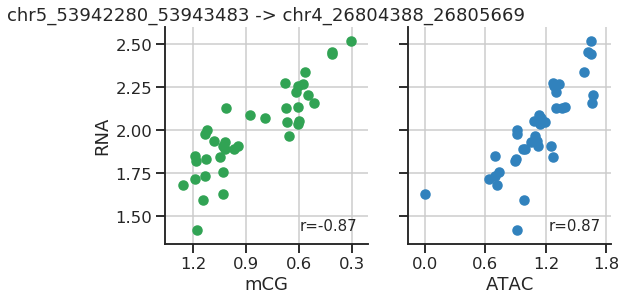

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Stim2_2020-12-13.pdf


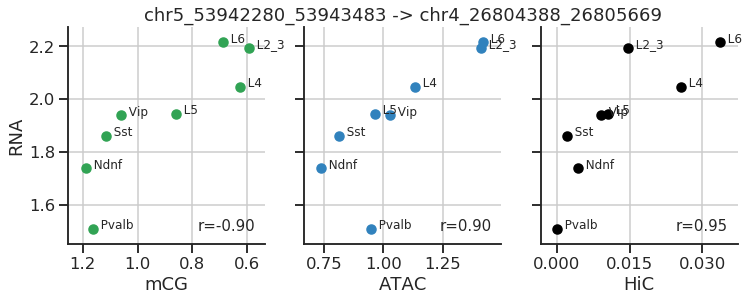

8it [00:00,  9.33it/s]


/cndd2/fangming/projects/scf_enhancers/figures/hic_map_nonorm_Stim2_10000_2020-12-13.pdf


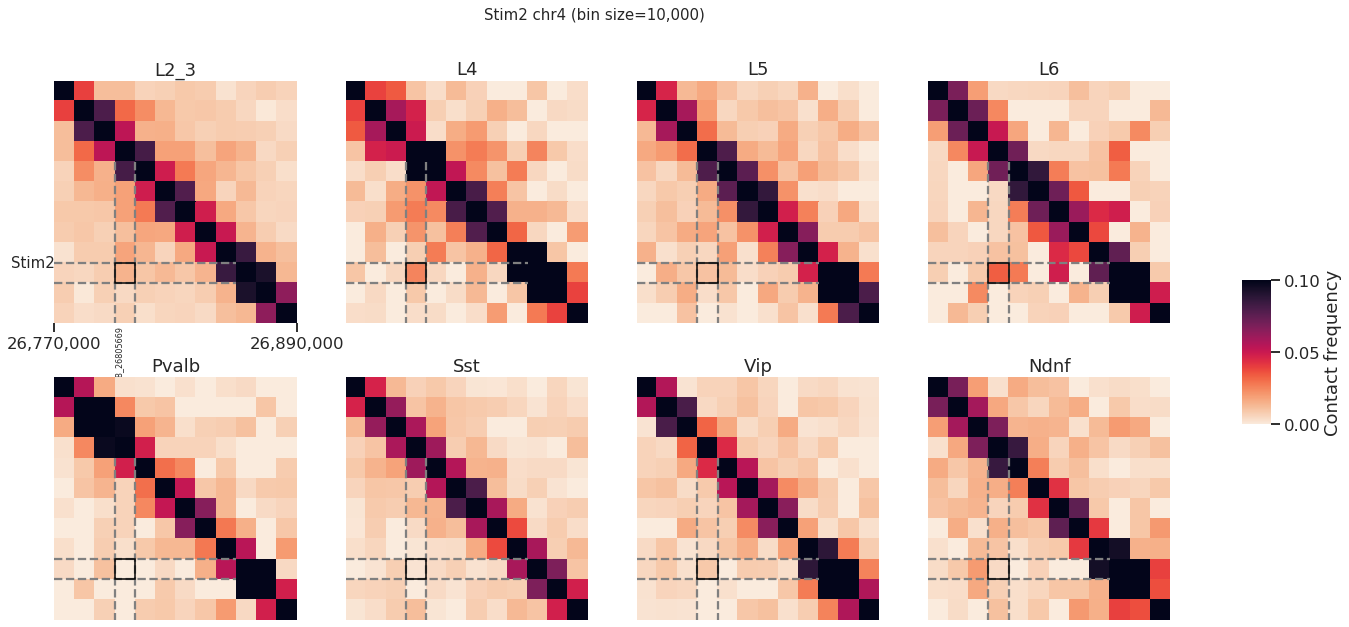

In [21]:
# plot
plot_scatter1(gene_name, enh_names_orig, enh_names_lifted, 
              ploty, plotx1, plotx2,
              subplot_colors_mc_atac)
plot_scatter2(gene_name, enh_names_orig, enh_names_lifted, 
             plotyb1, plotxb1, plotxb2, plotxb3, 
              subplot_colors_mc_atac_hic)

plot_mat_multi_enh_wholefig(celltypes, mats_all, 
                            enh_bins, gene_bin, enh_names_lifted, gene_name, 
                            chromosome, resolution, normalize=False, vmin=0, vmax=0.1, 
                           ) 

# apply to multiple genes using the summarized scheme

(3, 3)
chr22


100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


(3, 8)
/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Ift27_2020-12-13.pdf


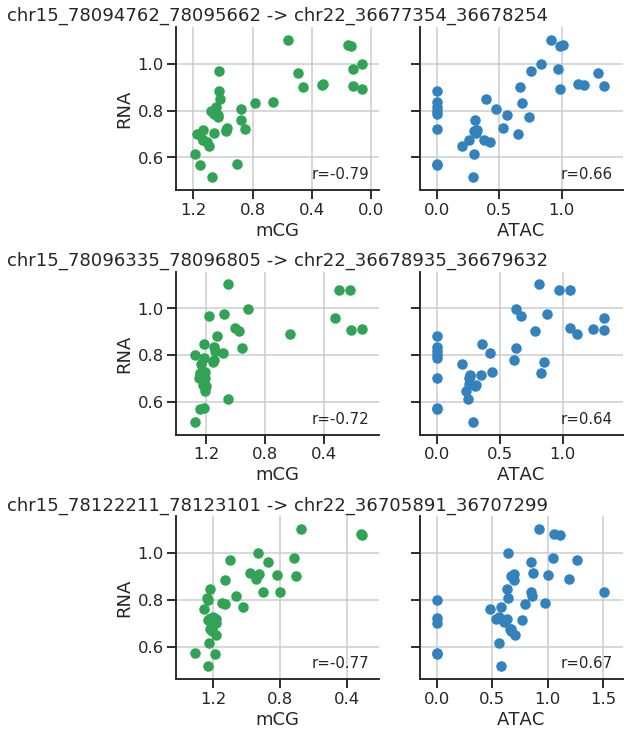

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Ift27_2020-12-13.pdf


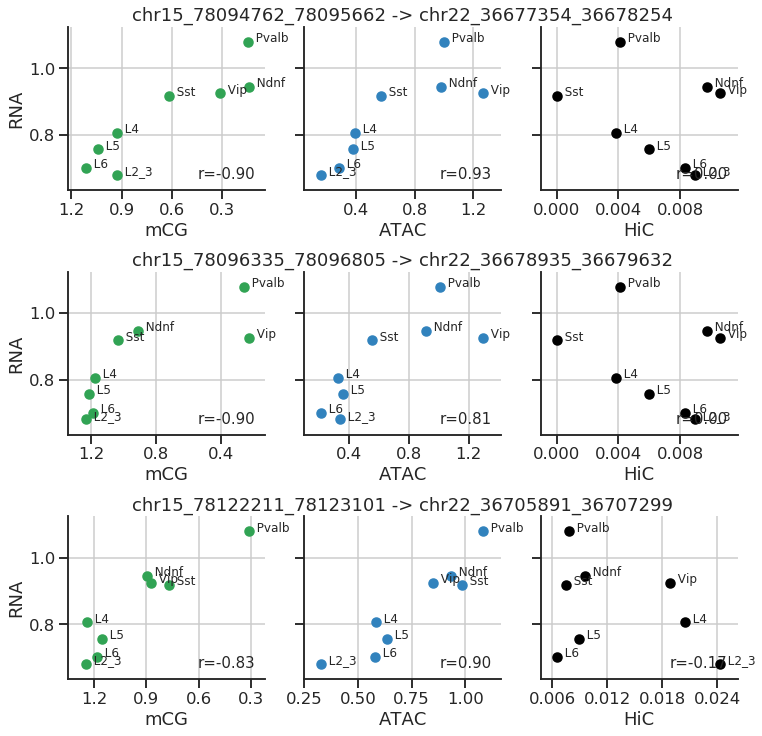

8it [00:00,  8.60it/s]


/cndd2/fangming/projects/scf_enhancers/figures/hic_map_nonorm_Ift27_10000_2020-12-13.pdf


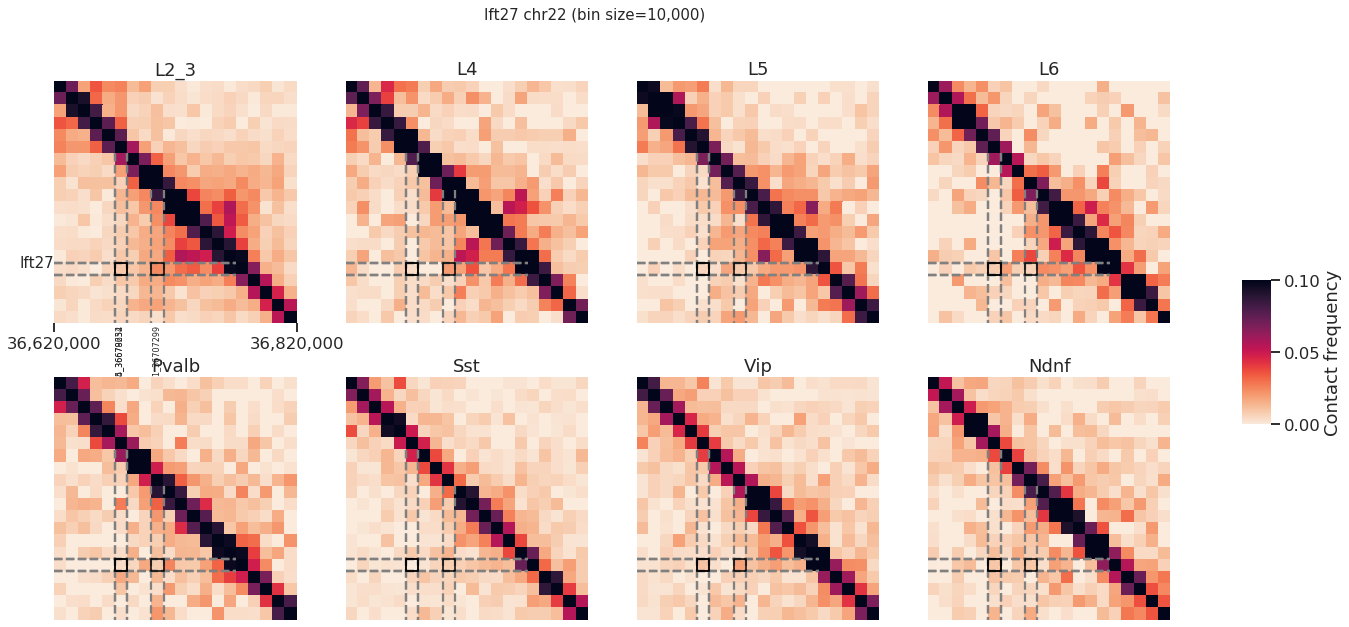

  0%|          | 0/8 [00:00<?, ?it/s]

(4, 3)
chr1


100%|██████████| 8/8 [00:34<00:00,  4.30s/it]


(1, 8)
/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Ier5_2020-12-13.pdf


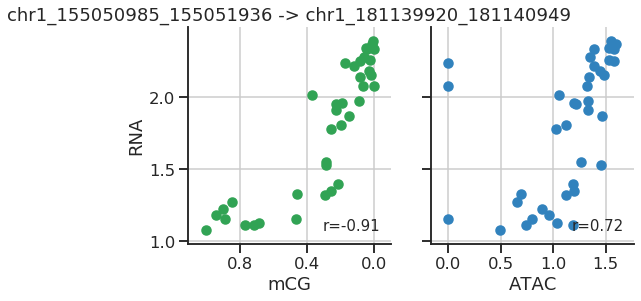

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Ier5_2020-12-13.pdf


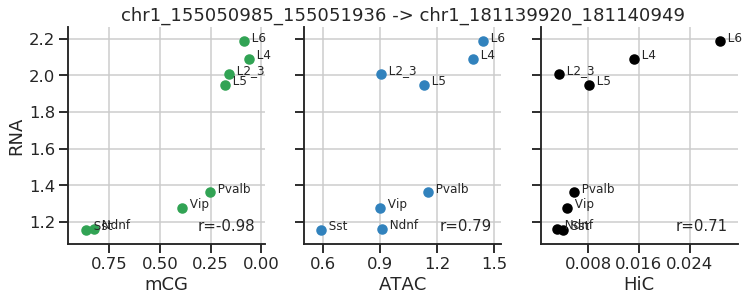

8it [00:00,  9.65it/s]


/cndd2/fangming/projects/scf_enhancers/figures/hic_map_nonorm_Ier5_10000_2020-12-13.pdf


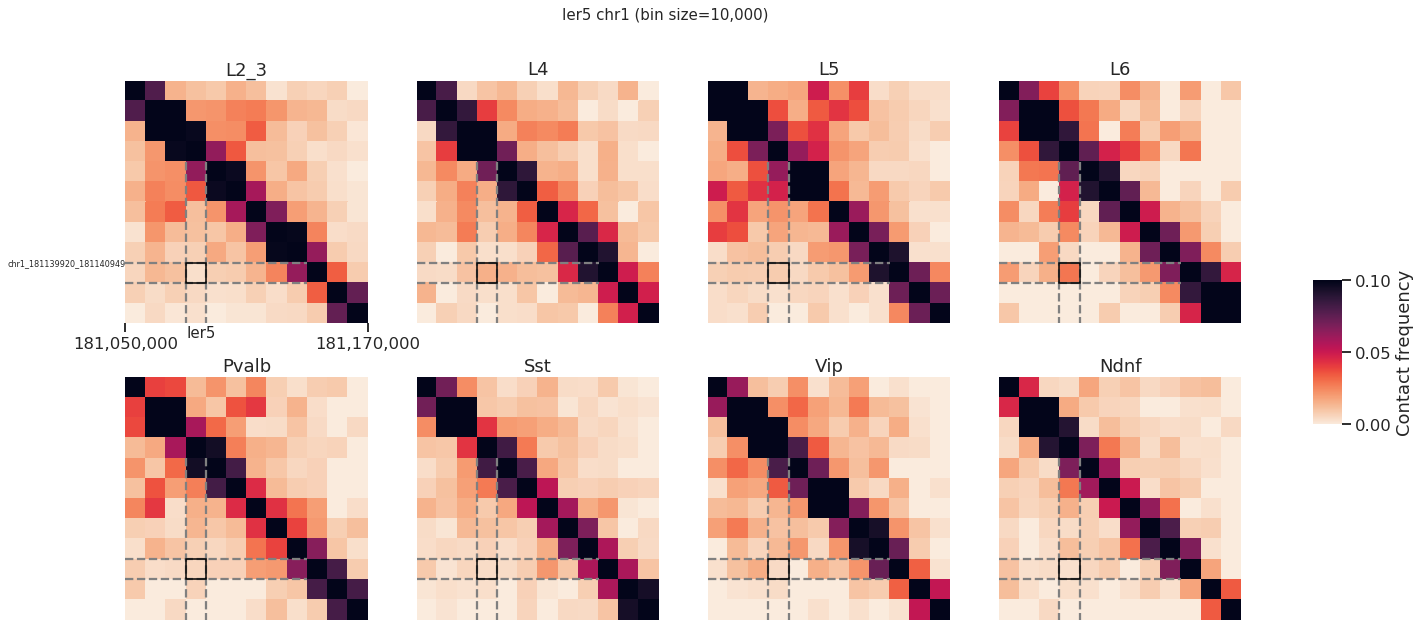

(17, 3)
chr4


100%|██████████| 8/8 [00:22<00:00,  2.78s/it]


(8, 8)
/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Afap1_2020-12-13.pdf


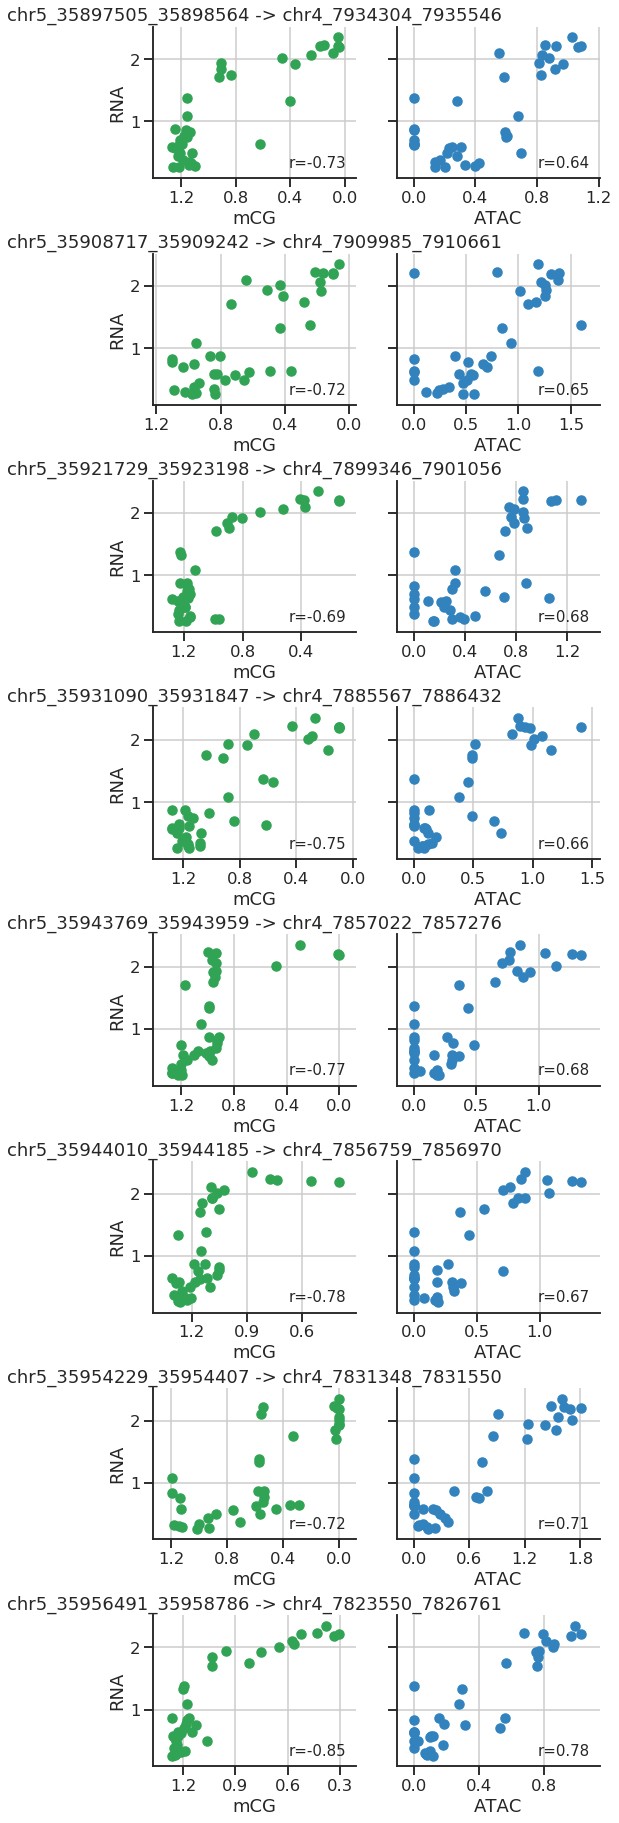

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Afap1_2020-12-13.pdf


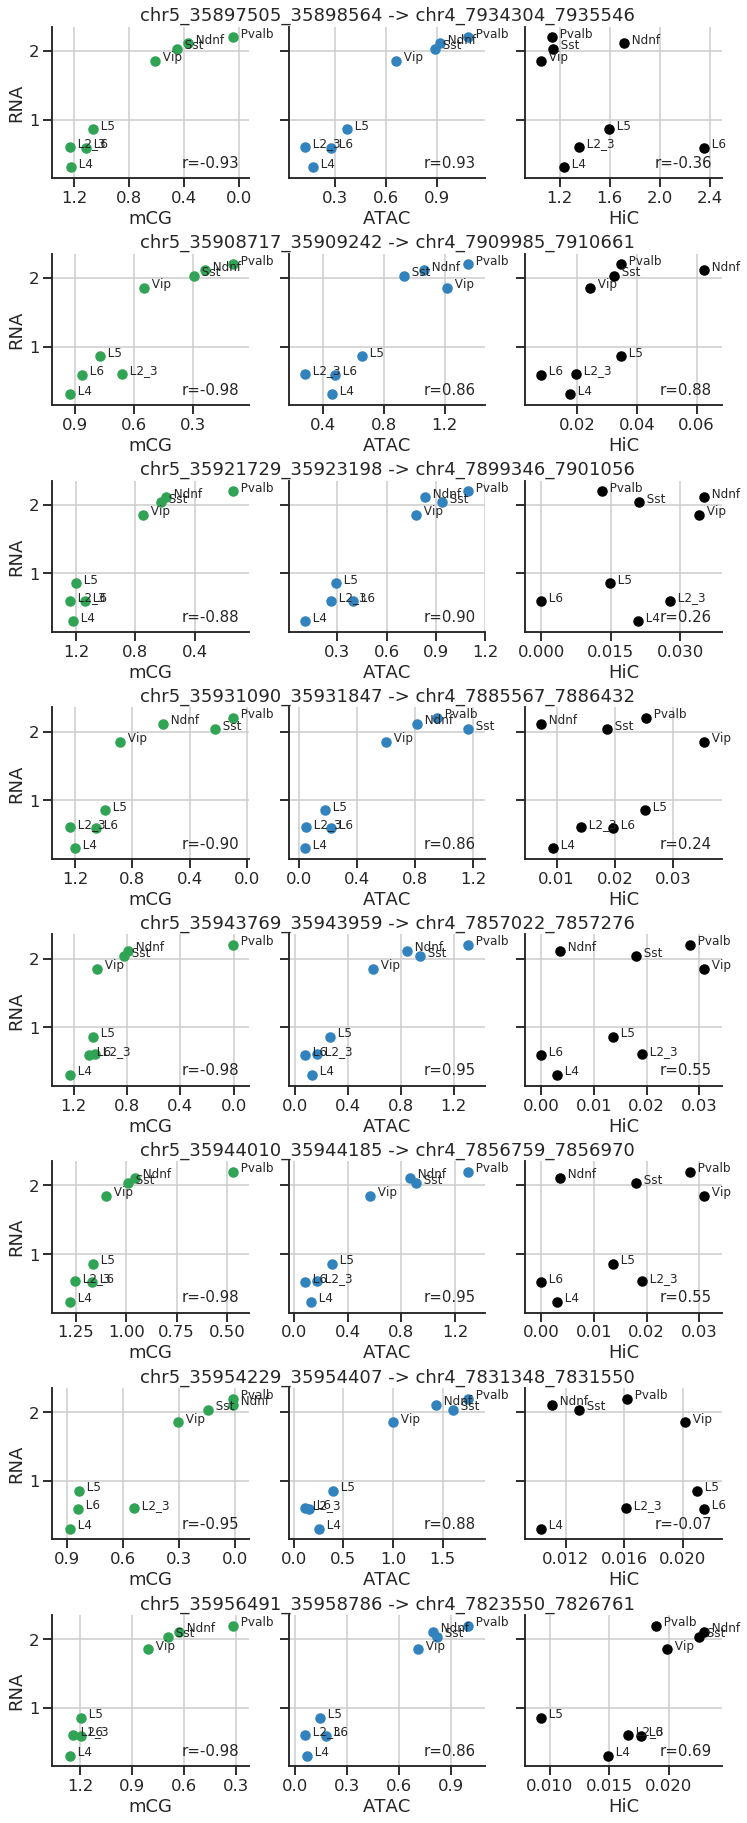

8it [00:01,  6.98it/s]


/cndd2/fangming/projects/scf_enhancers/figures/hic_map_nonorm_Afap1_10000_2020-12-13.pdf


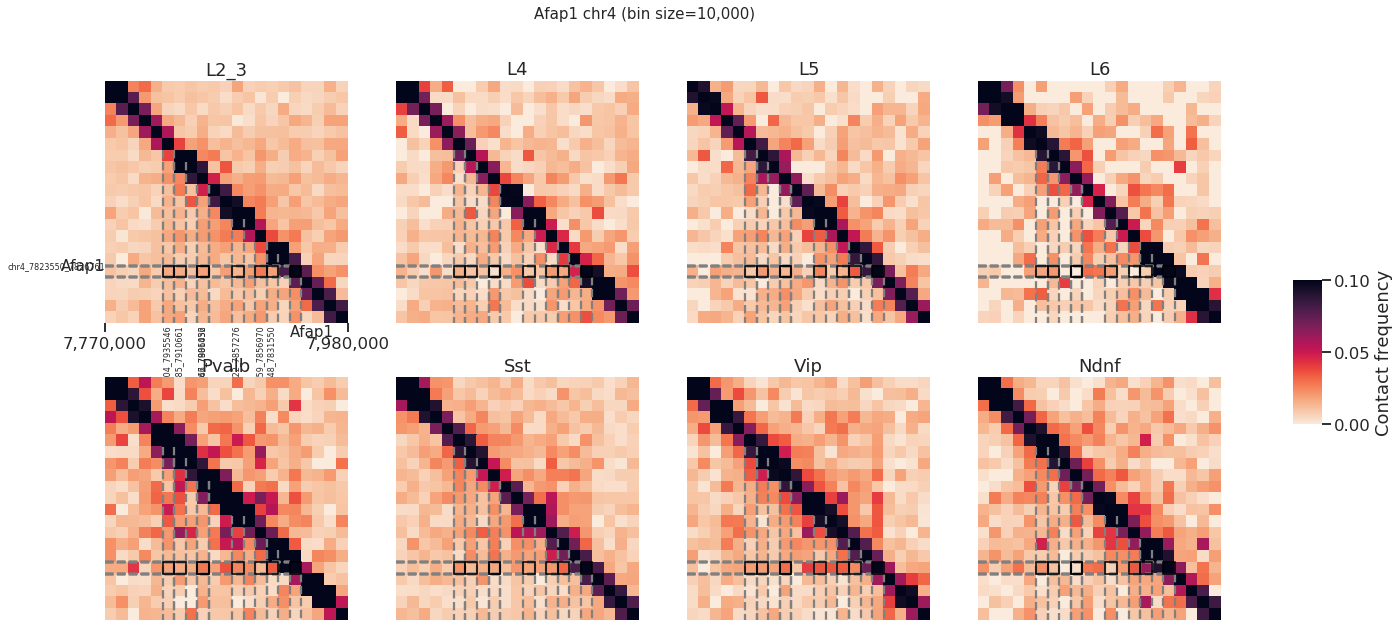

(3, 3)
chr7


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


(3, 8)
/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Neurod6_2020-12-13.pdf


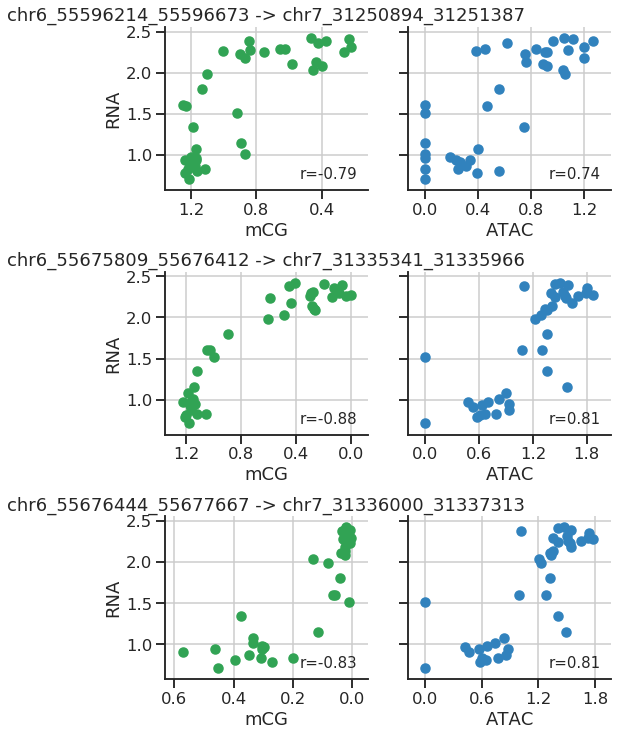

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Neurod6_2020-12-13.pdf


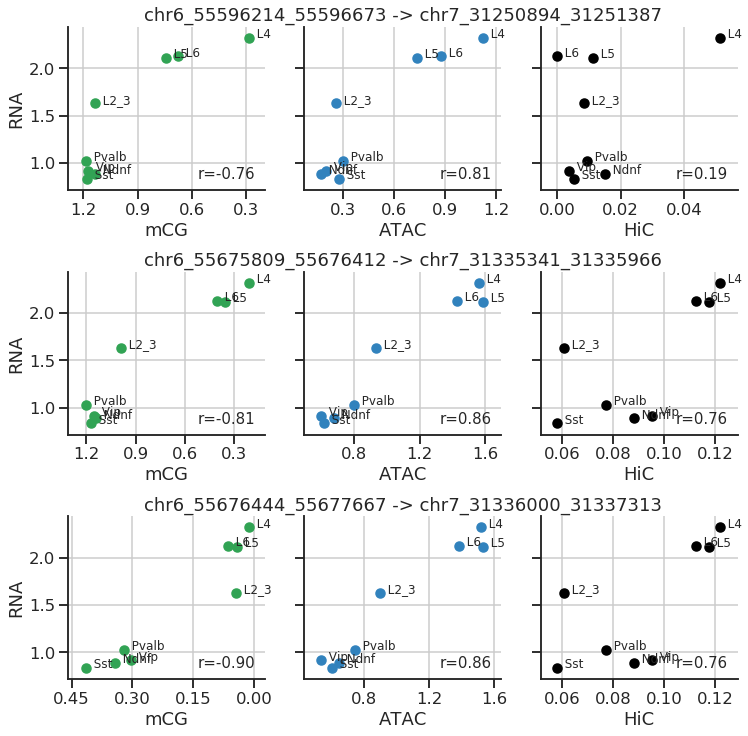

8it [00:00,  9.72it/s]


/cndd2/fangming/projects/scf_enhancers/figures/hic_map_nonorm_Neurod6_10000_2020-12-13.pdf


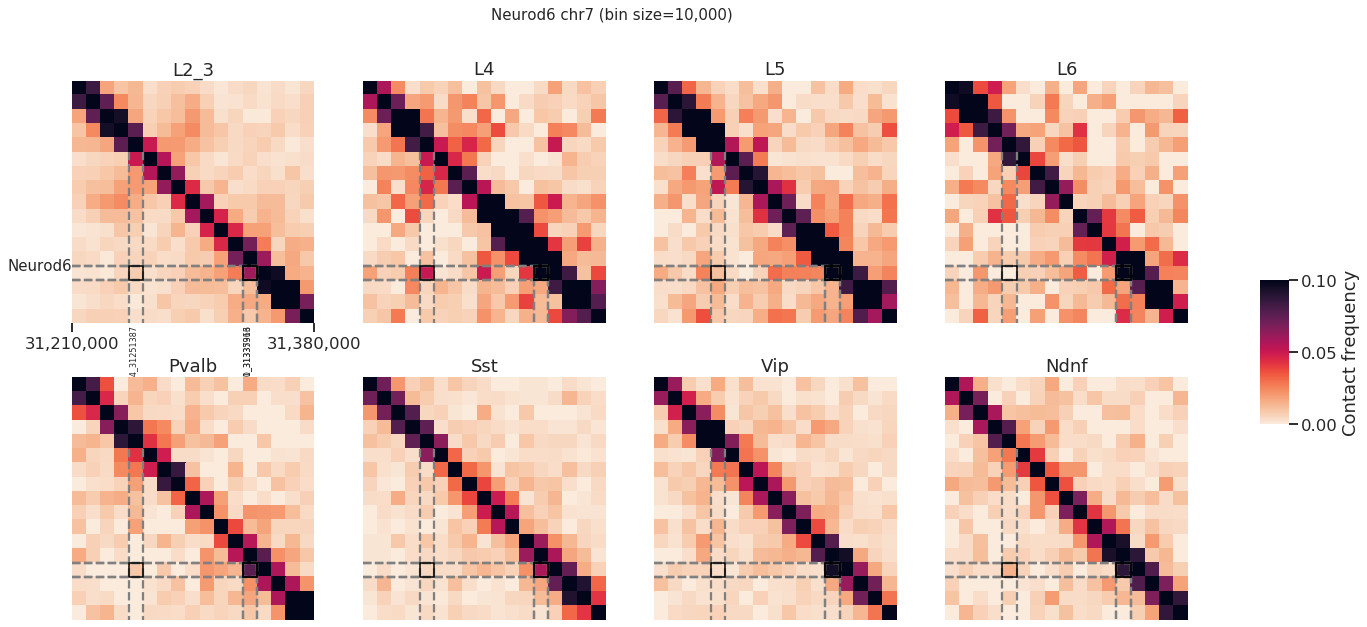

In [22]:
resolution = 10000
gene_name = 'Stim2'
gene_names = ['Ift27', 'Ier5', 'Afap1', 'Neurod6']

for gene_name in gene_names:
    try:
        gene_id = df_genes.reset_index().set_index('gene_name').loc[gene_name, 'gid']

        linked_pairs_todo = linked_pairs_both[linked_pairs_both['gene']==gene_id]
        chromosome_spec = tss_list.set_index('gid').loc[gene_id, 'chr']

        print(linked_pairs_todo.shape)
        print(chromosome_spec)
    except:
        print("{} skipped".format(gene_name))
    #         continue

    # get a list of candidate pairs
    chromosome = chromosome_spec
    # all enhancers and tss on that chromosomes
    enhs = enh_list[enh_list['chr']==chromosome]
    tsss = tss_list[tss_list['chr']==chromosome]
    # get paired bins
    paired_bin_table = enh_gene_id_to_binidx(linked_pairs_todo, tsss, enhs, resolution)


    # start from this
    paired_bin_table_spec = paired_bin_table #.iloc[[2]]

    # gene and enhs
    chromosome = chromosome_spec
    gene_bin = paired_bin_table_spec['gene_bin'].iloc[0]
    enh_bins = np.sort(paired_bin_table_spec['enh_bin'].values)

    gene_id = paired_bin_table_spec['gene'].iloc[0]
    enh_ids = paired_bin_table_spec['enh'].values
    enh_names_orig = ["_".join(enh_list_orig.set_index('index').loc[enh_id][['chr', 'start', 'end']].astype(str))
                            for enh_id in enh_ids]
    enh_names_lifted = ["_".join(row[['enh_chr', 'enh_start', 'enh_end']].astype(str)) 
                            for idx, row in paired_bin_table_spec.iterrows()]

    # get relevant mats
    mats_all = {}
    for celltype in tqdm.tqdm(celltypes):
        resource_string = (
             '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
             '::/resolutions/{}'.format(celltype, resolution)
             )
        c = cooler.Cooler(resource_string)
        mat_all = c.matrix(balance=True).fetch(chromosome)

        name = "{} {}".format(celltype, chromosome)

        if name not in mats_all.keys(): 
            mats_all["{} {}".format(celltype, chromosome)] = mat_all

    # get contacts on the specific location
    contact_by_clsts = []
    for i, (idx, row) in enumerate(paired_bin_table_spec.iterrows()):
        gene_bin, enh_bin = row[['gene_bin', 'enh_bin']]

        for celltype in celltypes:
            mat_all = mats_all["{} {}".format(celltype, chromosome)]
            val = mat_all[gene_bin, enh_bin]
            contact_by_clsts.append({
                        'local_pair_idx': i,
                        'celltype': celltype,
                        'contact': val, 
                       })
    contact_by_clsts = pd.DataFrame(contact_by_clsts)
    contact_by_clsts = contact_by_clsts.pivot(index='local_pair_idx', columns='celltype')['contact']
    print(contact_by_clsts.shape)

    # all info 
    ploty = gene_rna_clsts.loc[gene_id, shared_clusters]
    plotx1 = enh_mcg_clsts.loc[enh_ids, shared_clusters]
    plotx2 = enh_atac_clsts.loc[enh_ids, shared_clusters]

    # 38 clusters -> 8 clusters
    plotyb1 = summarize_by_broad_clsts(ploty.to_frame().T, clst_annot_broad)
    plotxb1 = summarize_by_broad_clsts(plotx1, clst_annot_broad)
    plotxb2 = summarize_by_broad_clsts(plotx2, clst_annot_broad)
    plotxb3 = contact_by_clsts

    # plot
    plot_scatter1(gene_name, enh_names_orig, enh_names_lifted, 
                  ploty, plotx1, plotx2,
                  subplot_colors_mc_atac,
                 )
    plot_scatter2(gene_name, enh_names_orig, enh_names_lifted, 
                  plotyb1, plotxb1, plotxb2, plotxb3, 
                  subplot_colors_mc_atac_hic,
                 )
    plot_mat_multi_enh_wholefig(celltypes, mats_all, 
                                enh_bins, gene_bin, enh_names_lifted, gene_name, 
                                chromosome, resolution, normalize=False, vmin=0, vmax=0.1)